In [1]:
import rubrix as rb
import modAL
import sklearn
import pandas as pd
from typing import List


/Users/maxine/Library/Python/3.9/lib/python/site-packages/jose/backends/cryptography_backend.py:18: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


## 1) get the data
need a labeled test set (initial_train, also called 'seed'), a pool of unlabeled data (pool) and a small labeled test set (test)
towardsdatascience AL tutorial
https://colab.research.google.com/drive/1G_4o-1_CkR4eNgzGVcx89IJ_lKLBQQv-?usp=sharing#scrollTo=zzfQjODjFwDs

In [3]:
# 1) (index), text, label
# initial_train = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # macbook
initial_train = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) #imac
initial_train.drop(columns=['text'], inplace = True)

# test = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # macbook
test = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # imac
test.drop(columns=['text'], inplace = True)

# pool = pd.read_csv('/Users/Maxine/Desktop/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # macbook
pool = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # imac

# Note: for some reason jupyter cannot find the relative path

In [4]:
initial_train.shape, test.shape, pool.shape

((3453, 2), (386, 2), (12579, 1))

[Text(0, 0, 'expl:pv'),
 Text(1, 0, 'expl:pass'),
 Text(2, 0, 'obj'),
 Text(3, 0, 'expl:impers'),
 Text(4, 0, 'iobj'),
 Text(5, 0, 'fixed'),
 Text(6, 0, 'flat')]

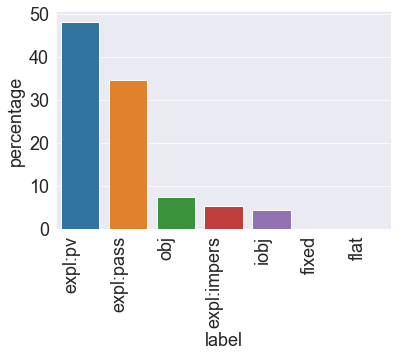

In [5]:
import matplotlib as plt
import seaborn as sns
label_counts_train = (initial_train['se_label']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index":"label"})
                     )

label_counts_test= (test['se_label']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index":"label"})
                     )

BIGGER_SIZE: int = 18
# plt.figure(figsize=(8,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

sns.set_style("darkgrid")

p_train = sns.barplot(x="label", y="percentage", data=label_counts_train)
p_train.set_xticklabels(p_train.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')


[Text(0, 0, 'expl:pv'),
 Text(1, 0, 'expl:pass'),
 Text(2, 0, 'obj'),
 Text(3, 0, 'expl:impers'),
 Text(4, 0, 'iobj')]

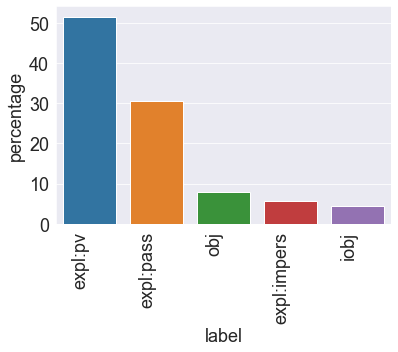

In [6]:
p_test = sns.barplot(x="label", y="percentage", data=label_counts_test)
p_test.set_xticklabels(p_test.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')

In [ ]:
# eventually save the plots
# plt.savefig('filename.png')
# plt.show()

## 2) encode textual data and labels
encode strings as vectors and pass them trough a Embedding layer

sklearn: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
fasttext & sklearn: https://ai.intelligentonlinetools.com/ml/fasttext-word-embeddings-text-classification-python-mlp/
Keras AL tutorial: https://keras.io/examples/nlp/active_learning_review_classification/?utm_source=pocket_mylist
for torch nn.model : https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f

In [21]:
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # todo change to es
# ft = fasttext.load_model('cc.en.300.bin') # rename model

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(initial_train.tokenized_text)
X_test = vectorizer.transform(test.tokenized_text)

y_train = initial_train.se_label
y_test = test.se_label

In [8]:
from sklearn import  preprocessing
label_encoder = preprocessing.LabelEncoder()

label_encoder.fit(y_train)

LabelEncoder()

In [9]:
print(list(label_encoder.classes_), label_encoder.transform(['expl:impers', 'expl:pass', 'expl:pv', 'fixed', 'flat', 'iobj', 'obj']))

['expl:impers', 'expl:pass', 'expl:pv', 'fixed', 'flat', 'iobj', 'obj'] [0 1 2 3 4 5 6]


## 3) train an initial model
we need X and y variables

can be done with ModAL active learner

In [10]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)



SVC()

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=['expl:impers', 'expl:pass', 'expl:pv','iobj', 'obj'], zero_division=0))

# todo compare predicted y to true y and get accuracy for initial model

              precision    recall  f1-score   support

 expl:impers       0.00      0.00      0.00        22
   expl:pass       0.58      0.18      0.27       118
     expl:pv       0.54      0.95      0.69       199
        iobj       0.00      0.00      0.00        17
         obj       0.00      0.00      0.00        30

    accuracy                           0.55       386
   macro avg       0.23      0.23      0.19       386
weighted avg       0.46      0.55      0.44       386



In [20]:
set(y_pred_test)

{'expl:pass', 'expl:pv'}

As seen above, the classifier has labeles the sentences in the test set only with the two most frequent labels in the training set > data imbalance

In [28]:
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner

learner = ActiveLearner(estimator=RandomForestClassifier(),
                        X_training=X_train, y_training=y_train
                        )

In [29]:
# Number of instances we want to annotate per iteration
n_instances = 5

# Accuracies after each iteration to keep track of our improvement
accuracies = []

In [46]:
X_pool = vectorizer.transform(pool.text)
X_pool

<12579x17315 sparse matrix of type '<class 'numpy.int64'>'
	with 234049 stored elements in Compressed Sparse Row format>

reejecutar desde aqui


In [53]:
from sklearn.exceptions import NotFittedError

# query examples from our training pool with the most uncertain prediction
query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)

# get predictions for the queried examples
try:
    probabilities = learner.predict_proba(X_pool[query_idx])
# For the very first query we do not have any predictions
except NotFittedError:
    probabilities = [[0.2, 0.2,0.2, 0.2, 0.2]]*n_instances

In [54]:
probabilities

array([[0.29, 0.28, 0.33, 0.  , 0.  , 0.02, 0.08],
       [0.25, 0.33, 0.19, 0.  , 0.  , 0.09, 0.14],
       [0.07, 0.33, 0.33, 0.  , 0.  , 0.12, 0.15],
       [0.23, 0.35, 0.34, 0.  , 0.  , 0.04, 0.04],
       [0.02, 0.28, 0.34, 0.  , 0.  , 0.03, 0.33],
       [0.09, 0.34, 0.31, 0.  , 0.  , 0.04, 0.22],
       [0.23, 0.35, 0.34, 0.  , 0.  , 0.03, 0.05],
       [0.13, 0.35, 0.35, 0.  , 0.  , 0.1 , 0.07],
       [0.35, 0.17, 0.35, 0.  , 0.  , 0.03, 0.1 ],
       [0.08, 0.36, 0.34, 0.  , 0.  , 0.11, 0.11]])

In [57]:
import rubrix as rb

# Build the Rubrix records
records = [
    rb.TextClassificationRecord(
        id=idx,
        inputs=pool.text.iloc[idx], # not CONTENT as in docs
        # prediction=list(zip(["HAM", "SPAM"], probs)),
        prediction=list(zip(['expl:pass', 'obj', 'expl:impers', 'iobj', 'expl:pv'], probs)),
        prediction_agent="RandomForestClassifier",
    )
    for idx, probs in zip(query_idx, probabilities)
]

# Log the records
rb.log(records, name="active_learning_se_corpus")

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/active_learning_se_corpus


BulkResponse(dataset='active_learning_se_corpus', processed=10, failed=0)

In [ ]:
## Load it back into pandas

In [64]:
# Load the annotated records into a pandas DataFrame
records_df = rb.load("active_learning_se_corpus", ids=query_idx.tolist())

# check if all examples were annotated
if any(records_df.annotation.isna()):
    raise UserWarning("Please annotate first all your samples before teaching the model")

# train the classifier with the newly annotated examples
# y_pool = records_df.annotation.map(lambda x: int(x == "SPAM"))
y_pool = records_df.annotation
# learner.teach(X=X_pool[query_idx], y=y_pool.to_list())
learner.teach(query_inst, y_pool)                                             # todo, consult modal active learning with jupyter 

# Keep track of our improvement
accuracies.append(learner.score(X=X_test, y=y_test)) # not CLASS as in docs

TypeError: <class 'pandas.core.series.Series'> datatype is not supported

In [34]:
print(accuracies)

[0.0]


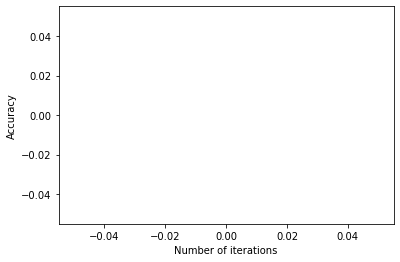

In [35]:
import matplotlib.pyplot as plt

# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy");